# Project 1

The goal of this project is to perform an analysis on a one-dimensional signal. Our proposal is to Train a deep learning model (RNN as it should work best on sequential data) to classify sleep stages (e.g., REM, NREM, awake) using multi-channel EEG signals. To do so we'll first analyze the dataset at our disposal, then, make our analysis and predictions.

## Step 0: Setup

In [1]:
!pip install -r requirements.txt

define a function to import everything needed (this will be required later)

In [2]:
import gc #garbage collector
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
import h5py
from torch.utils.data import Dataset, ConcatDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import LeavePGroupsOut
from torch.utils.data import ConcatDataset

# Classification tools
from sklearn.metrics import accuracy_score
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import nolds 
from scipy.signal import detrend

## nn tools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import copy
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import confusion_matrix

%matplotlib inline
mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [3]:
# Identify whether a CUDA-enabled GPU is available
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

No GPU found. Training will be carried out on CPU, which might be slower.



## Step 1: Reading the set

### Small introduction to the dataset

The 88 ST* files (ST = Sleep Telemetry) were obtained in a 1994 study of temazepam effects on sleep in 22 Caucasian males and females without other medication. Subjects had mild difficulty falling asleep but were otherwise healthy. The PSGs of about 9 hours were recorded in the hospital during two nights, one of which was after temazepam intake, and the other of which was after placebo intake. Subjects wore a miniature telemetry system with very good signal quality.

EOG, EMG and EEG signals were sampled at 100 Hz, and the event marker at 1 Hz

Files are named in the form ST7ssNJ0-PSG.edf where ss is the subject number, and N is the night.

### Explore the EEG and Hypnogram files structure

In order to retrive the data from our dataset we will have to use:
- the 44 ...-PSG.edf files as our EEG. 
- the 44 ...-Hypnogram.edf files as our labels to find sleep stages.

First we want to read all files inside, our dataset, then we will filter other data out to keep only EEGs

In [4]:
# Path to the directory containing your EDF files
data_dir = "./sleep-telemetry"
# List all PSG and Hypnogram files
edf_files = [f for f in os.listdir(data_dir) if f.endswith('.edf')]

# Separate PSG and Hypnogram files
psg_files = [f for f in edf_files if '-PSG' in f]
hypnogram_files = [f for f in edf_files if '-Hypnogram' in f]

In [5]:
print(len(psg_files))
print(len(hypnogram_files))

44
44


Then we make sure al files have a curresponding annotation file:

In [6]:
# Create a dictionary mapping PSG to Hypnogram based on subject and night
psg_to_hypnogram = {}
for psg_file in psg_files:
    subject_night = psg_file.split('J0-PSG')[0]  # Extract subject and night (e.g., ST7ssNJ0)
    for hypno_file in hypnogram_files:
        if subject_night in hypno_file:
            psg_to_hypnogram[psg_file] = hypno_file
            break

print(f"Total matched PSG-Hypnogram pairs: {len(psg_to_hypnogram)}")

Total matched PSG-Hypnogram pairs: 44


Now we want to load the first file and take a look at his informations to better understand what we are dealing with:

In [7]:
example_eeg = list(psg_to_hypnogram.keys())[0]
example_desc = psg_to_hypnogram[example_eeg]

example_eeg = os.path.join(data_dir, example_eeg)
example_desc = os.path.join(data_dir, example_desc)

In [8]:
raw = mne.io.read_raw_edf(example_eeg)
annots = mne.read_annotations(example_desc)
raw.set_annotations(annots, emit_warning=False)

print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental, Marker
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-07-12 23:00:00 UTC
 nchan: 5
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | his_id: X, sex: 1, first_name: Male, last_name: 60yr>
>


After a quick research on the web those are the infrormations that arise about each of the 5 channels of our EEG:

1. **EEG Fpz-Cz**: This is a standard EEG channel that records brain activity. $\to$ 
we keep it as an EEG channel as it could be important to learn on

2. **EEG Pz-Oz**: Another standard EEG channel. $\to$ 
we keep it as an EEG channel as it could be important to learn on

3. **EOG horizontal**: Electrooculography (EOG) is used to monitor eye movements. Eye movements are crucial for detecting REM sleep $\to$ 
we keep it as an EEG channel as it is very clearly much important to learn on (in our use-case)

4. **EMG submental**: Electromyography (EMG) from submental (chin) muscles. Submental EMG is vital for detecting muscle tone, which helps differentiate between REM sleep (low muscle tone) and other stages $\to$ 
apparently this channel is useful too to analyze sleep stages

5. **Marker**: Typically used for event markers or annotations. $\to$ we can scrap this channel

therefore we create this mapping dictionary to assign to 'misc' all usless channels:

In [9]:
# Mapping of channel names to types that we want to delete
mapping = {'Marker': 'misc',
           'Resp oro-nasal': 'misc',  # not present in our case
           'Temp rectal': 'misc' } # not present in our case

Now, in order to read all files we define a function that will read one EEG at a time and deletes useless channels:

In [10]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    
    exclude = mapping.keys() if load_eeg_only else ()

    # Load raw data and annotations
    original_fname = raw_fname
    raw_fname = os.path.join(data_dir, raw_fname)
    annot_fname = os.path.join(data_dir, annot_fname)
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = max(0, annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60)
        tmax = min(raw.times[-1], annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60)
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording night information in raw.info
    basename = os.path.basename(original_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    concat = f'{subj_nb}{rec_nb}' 

    raw.info['subject_info'] = {'id': int(concat) }
   
    return raw

Let's show the same sample as before, to understand what we are working whith:

In [12]:
# Load recordings
example_file = load_sleep_physionet_raw(list(psg_to_hypnogram.items())[1][0], list(psg_to_hypnogram.items())[1][1])

# Display basic information about the recording
example_file.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz, EOG horizontal, EMG submental
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-07-19 23:47:00 UTC
 nchan: 4
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | id: 12>
>

As we can see, now we only have 4 channels, instead of prevoius 5. 

Now we can also show the raw eeg wave signal:

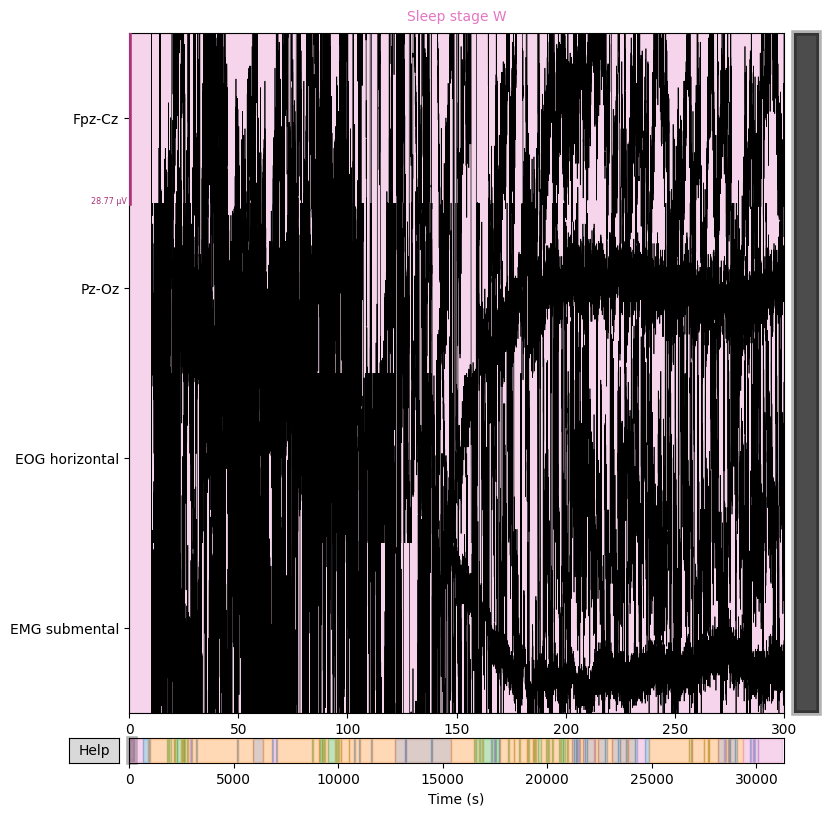

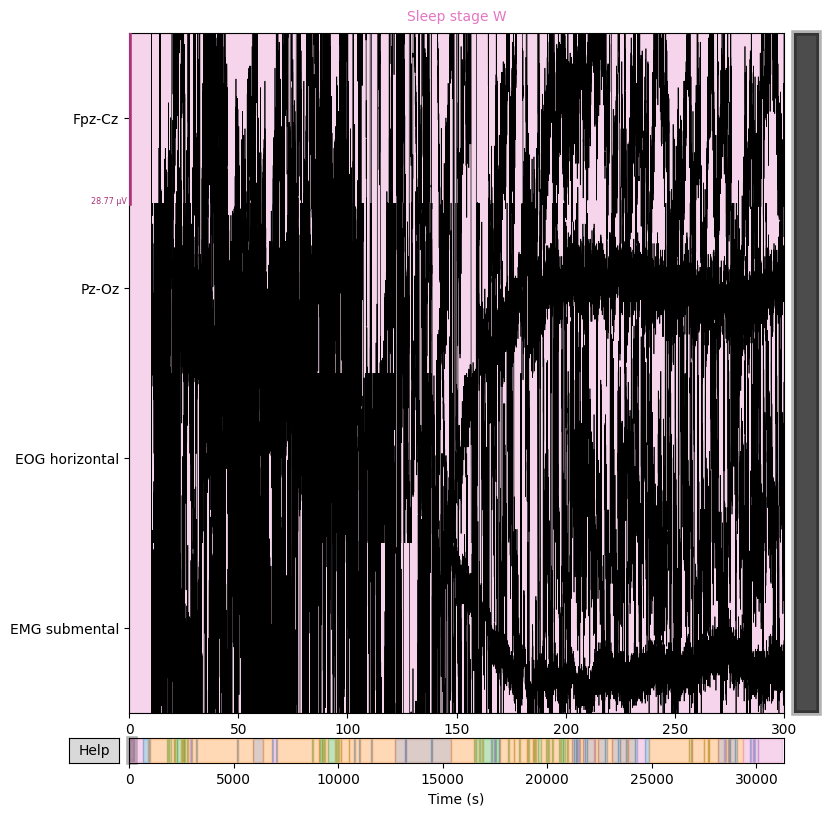

In [13]:
# Plot raw EEG data (for visualization)
example_file.plot(duration=300, n_channels=4, scalings='auto')

And we can clearly now see we are dealing with a monodimensional signal whit 4 channels

### Extract sleep stages from hypnogram

What we are doing here is essentially preparing the data from hypnogram files in order to get our labels. In this step we just need to get the raw hypnograms

In [14]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in psg_to_hypnogram.items()]

We also save in a variable both frequencies and number of channels as they might be useful later:

In [15]:
sfreq = raws[1].info['sfreq']  # Sampling frequency
n_channels = raws[1].info['nchan']  # Number of channels

## Step 2: Data preparation

### Filter signal

Following a brief online search, it was determined that the most relevant information in sleep EEG data resides below 30 Hz. To reduce the influence of higher-frequency noise, we apply a low-pass filter with a cutoff frequency of 30 Hz to our recordings.

In [16]:
bottom_freq, top_freq = None, 30

for raw in raws:
    raw.load_data().filter(bottom_freq, top_freq)  # filter data locally

We then plot the power spectrum of a recording as sanity check:

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


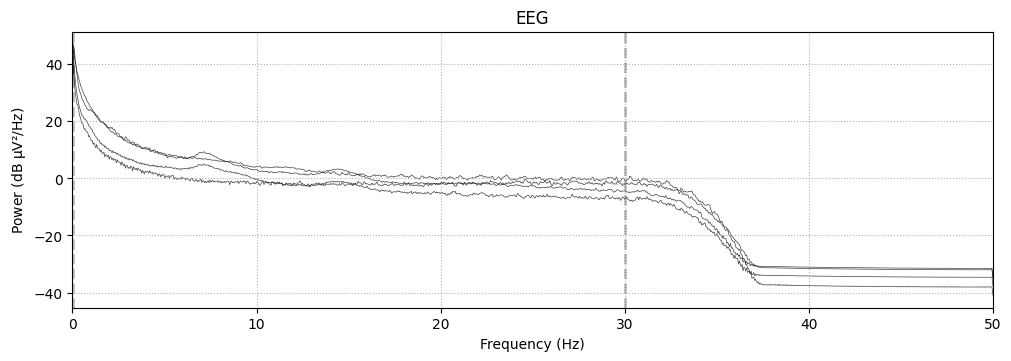

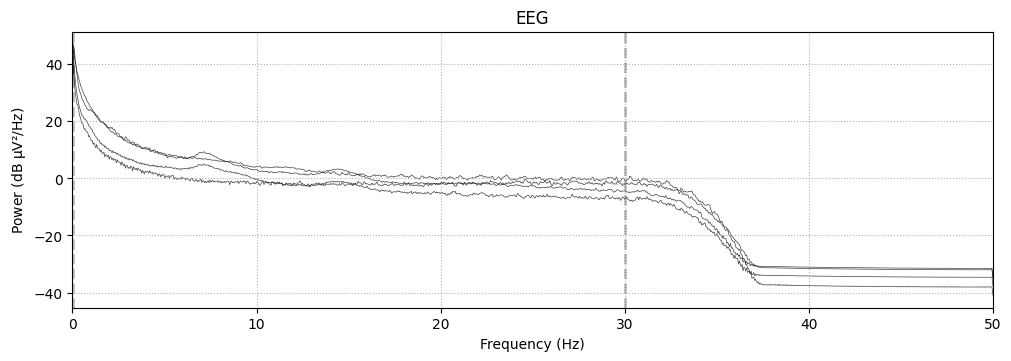

In [17]:
# Plot the power spectrum
raws[0].plot_psd()

The filter's effect is evident near 30 Hz. The sharp drop in power after this frequency suggests that the low-pass filter effectively attenuated frequencies above 30 Hz on all 4 channels, as intended.

### Extract epochs

We can now proceed to extract epochs. Wich just means creating 30 seconds long samples (and respective label of sleep stage) from our recordings so that we can later use those to define out train / validation / test sets.

Also we prepare this this dictionary to classify events of each recording into 4 sleep stages classes (we merge class 3 and 4 for convenience):

In [18]:
expected_stages = {
    'Sleep stage W': 1,  # Wake
    'Sleep stage 1': 2,  # NREM 1
    'Sleep stage 2': 3,  # NREM 2
    'Sleep stage 3': 4,  # NREM 3
    'Sleep stage 4': 4,  # Combine stage 3 and 4 (deep sleep)
    'Sleep stage R': 5   # REM sleep
}

# Create a new event_id that unifies stages 3 and 4
event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,  # Combined stage 3 and 4
    'Sleep stage R': 5
}

those are:

1. **Stage 1 Sleep**

    Stage 1 sleep is called light or transition sleep. It is the transition from wakefulness to sleep. It is characterized by the gradual slowing of the EEG. Often patients will be awake, with eyes closed and demonstrate alpha rhythms as they slip into stage 1. This rhythm begins to slowly widen and slow and take on the characteristics of theta rhythm. Theta activity comprises most of the EEG activity in stage 1.

    Besides theta waves, one is apt also to see occasional vertex sharp waves. There are no spindles or K complexes in this stage. In observing the eyes, one also notes slow rolling eye movements, each stretching more than several seconds long. These are more prominent in the early portion of stage 1, but gradually disappear as this phase progresses. Myoclonic twitches of the limb muscles may occur. Once alpha rhythms decrease to less than 50% of the epoch and theta rhythms occupy more than 50%, stage 1 can be scored. Stage 1 sleep occupies between 5% and 7% of a normal subject’s total sleep time.

<br>

2. **Stage 2 Sleep**

    Stage 2 sleep begins with the appearance of spindles and K complexes. The background frequency is between 1 Hz and 5 Hz and is of low amplitude. Since K complexes and spindles are intermittent phenomena, a time factor must be considered in order to properly score this stage. Known as the 3 Minute Rule, this factor states that if more than 3 minutes elapse since the time of the last K complex or sleep spindle, then the intervening epochs are scored as Stage 1. If less than 3 minutes (6 x 30-second epochs) pass before another K complex or spindle occurs, then the intervening epochs continue to be scored as stage 2. If movement artifact or stage wake appears within 3 minutes, then the stage is still scored as stage 2 but only up to the point of the arousal. After an arousal, scoring rules reset themselves and the resuming epochs are scored as stage 1 until a K complex or spindle appears again. It is very important to keep track of the epoch scores that proceeded the epoch under consideration. Stage 2 usually occupies about 50% of a normal night’s sleep time.

<br>

3. **Delta Sleep—Stages 3 and 4**
    
    Delta sleep is also known as slow wave sleep (SWS) or deep sleep. It is comprised of both stages 3 and 4. These are characterized by slow, high amplitude waves with a frequency of less than 2 Hz and an amplitude of at least 75 mV. K complexes and spindles may be present throughout delta sleep but may be obscured. This type of sleep makes up about 25% of a normal adult’s sleep. In children, teenagers, and young adults, it may be much more prevalent. Stage 3 is present when between 20% and 50% of an epoch is composed of delta waves, although sometimes it can be difficult to discern between stage 2 and stage 3. In order to quantify the amount of an epoch that is comprised of delta waves, one must measure the width of each waveform and add them together to determine the time axis occupied. Stage 4 sleep is present when more than 50% of an epoch is composed of delta waves.

<br>

4. **REM Sleep**

    REM sleep is often referred to as paradoxical or active sleep. It is the sleep stage when dreaming occurs. If present, the EEG drops to a mixed frequency, mostly low voltage recording. One can differentiate between stage 1 and REM by looking at the chin EMG lead. The amplitude in stage REM is extremely low whereas it is higher in stage 1. In fact, during REM the chin EMG should be at its lowest point of the whole night. Short phasic twitches of the limb muscles may occur during REM, although normal individuals are completely paralyzed during REM.
    
    Another factor that helps to diagnose REM is the presence of rapid eye movements that appear intermittently throughout this stage. Respiratory variation as well as cardiac sinus arrhythmia can be present, especially during phasic REM. Spindles also occur on occasion during REM, which can make differentiating between REM and stage 2 a little more difficult. As long as the time between spindles is 3 minutes or more, the stage is scored as REM. EMG tone is the ultimate arbiter in many cases. Comparing chin tone during stage 2 and the stage in question is helpful. Sawtooth waves can also sometimes be seen during REM. These are waves that have a narrowed, triangular appearance running at frequencies of 2 Hz to 6 Hz and at amplitudes between 40 mV and 100 mV. They usually occur for a few seconds at a time.

----

We can also help us visualize a sample labels to better understand how many times a sleep phase could change in just during a whole night:

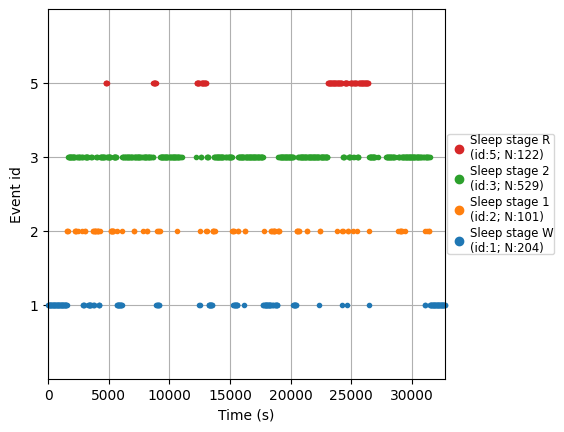

In [19]:
events, event_id_for_plot = mne.events_from_annotations(
        raws[0], event_id=event_id, 
        chunk_duration=30., verbose=False)

# plot events
mne.viz.plot_events(events, event_id=event_id_for_plot, sfreq=raw.info['sfreq'])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Then we can proceed to define a function to extract epochs from our recordings:

In [20]:
def extract_epochs(raw, chunk_duration=30.):
    # Convert annotations to events
    events, _ = mne.events_from_annotations(
        raw, event_id=expected_stages, 
        chunk_duration=chunk_duration)

    # Time limits
    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)

    try:
        # Create epochs based on the events
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    except ValueError as e:
        # If the event ID doesn't match any events, handle it gracefully
        print(f"Warning: {e}. Proceeding without some events.")
        # Set the placeholder for the missing event ID (e.g., 0 or -1)
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=None, tmin=0., tmax=tmax, baseline=None)

    # Get the event IDs (adjusted to match your new unified event_id)
    epoch_event_ids = epochs.events[:, 2] - 1  # Adjust event IDs
    unique_events = np.unique(epoch_event_ids)

    # Check for missing event labels, and assign a placeholder value (e.g., 0)
    for event in event_id.values():
        if event not in unique_events:
            # Replace all occurrences of this event with a placeholder (0 or -1)
            epoch_event_ids[epoch_event_ids == event] = 0  # Placeholder value

    return epochs.get_data(), epoch_event_ids
    # epochs.get_data() --> Epoched data, of shape (n_epochs, n_channels, n_times).
    # epoch_event_ids --> Event identifiers for each epoch, shape (n_epochs,).

We also write this support function to retrive subject number and night number from raw data (otherwise we would leave it behind):

In [21]:
# Extract subject numbers (subj_nb) from the 'id' field in raw.info['subject_info']
def extract_subj_nb_from_id(raw):
    # Extract the combined id from subject_info
    combined_id = str(raw.info['subject_info']['id'])
    
    if len(combined_id) == 2:
        subj_nb = combined_id[0]
        rec_nb = combined_id[1]  # The last digit is rec_nb
        
    else:
        # Derive subj_nb and rec_nb
        subj_nb = combined_id[0:2]
        rec_nb = combined_id[2]  # The last digit is rec_nb

    return int(rec_nb), int(subj_nb)

And then call both functions:

In [22]:
# Align annotations with EEG data
eeg_epochs = []
eeg_epochs_subj_ninght = []
labels = []

for raw in raws:
	# Extract epochs and labels
	epochs, lbls = extract_epochs(raw)
	eeg_epochs.append(epochs)
	labels.append(lbls)
		
	# Extract the combined id from subject_info
	combined_id = str( raw.info['subject_info']['id'] )
	rec_nb,subj_nb = extract_subj_nb_from_id(raw)
	print(f"Subject {subj_nb}, recording {rec_nb}")
	print(f"shape: {epochs.shape} --> label: {len(lbls)}")
	eeg_epochs_subj_ninght.append( (subj_nb, rec_nb) )

Subject 1, recording 1
shape: (1092, 4, 3000) --> label: 1092
Subject 1, recording 2
shape: (1040, 4, 3000) --> label: 1040
Subject 2, recording 1
shape: (920, 4, 3000) --> label: 920
Subject 2, recording 2
shape: (944, 4, 3000) --> label: 944
Subject 4, recording 1
shape: (959, 4, 3000) --> label: 959
Subject 4, recording 2
shape: (1103, 4, 3000) --> label: 1103
Subject 5, recording 1
shape: (1018, 4, 3000) --> label: 1018
Subject 5, recording 2
shape: (1034, 4, 3000) --> label: 1034
Subject 6, recording 1
shape: (1008, 4, 3000) --> label: 1008
Subject 6, recording 2
shape: (952, 4, 3000) --> label: 952
Subject 7, recording 1
shape: (821, 4, 3000) --> label: 821
Subject 7, recording 2
shape: (802, 4, 3000) --> label: 802
Subject 8, recording 1
shape: (947, 4, 3000) --> label: 947
Subject 8, recording 2
shape: (931, 4, 3000) --> label: 931
Subject 9, recording 1
shape: (943, 4, 3000) --> label: 943
Subject 9, recording 2
shape: (923, 4, 3000) --> label: 923
Subject 10, recording 1
shap

As we can see we'll have that each epoch will have  
- epoch.shape = (n_epochs, n_channels, n_times)
- label.shape = (n_epochs)

In [23]:
print(eeg_epochs[0].shape)
print(labels[0].shape)

(1092, 4, 3000)
(1092,)


### Standard scaling + Save as dataset

Since our goal is to classify and predict using features extracted from EEG epochs, standard scaling is often beneficial, therefore we apply standard scaling of data along the last dimention:

In [24]:
def scale(X):
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

Also, since we are later planning on using tensorlow to develop a model to learn on this data we define this class to expose an MNE Epochs object as PyTorch dataset. 

In [25]:
class EpochsDataset(Dataset):
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, rec_nb=None, scaling_function=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.scaling_function = scaling_function

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.scaling_function is not None:
            X = self.scaling_function(X)
        X = torch.as_tensor(X[None, ...])
        return X, y

Once both of this codeblocks are defined we can now encoede our dataset into an object list:

In [26]:
# Initialize an empty list for all datasets
all_datasets = []
flattened_before = eeg_epochs[0].flatten()

# Loop through each raw object to extract data and metadata
for sample, notes, label in zip(eeg_epochs, eeg_epochs_subj_ninght, labels):
    # Create the dataset and append it to the list
    dataset = EpochsDataset(epochs_data=sample,
                            epochs_labels=label,
                            subj_nb=notes[0], 
                            rec_nb=notes[1],
                            scaling_function=scale)
    all_datasets.append(dataset)

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)
flattened_after = dataset[0][0].flatten()

To test effect of scaling we print the before and after of a random signal to verify scaling has done something:

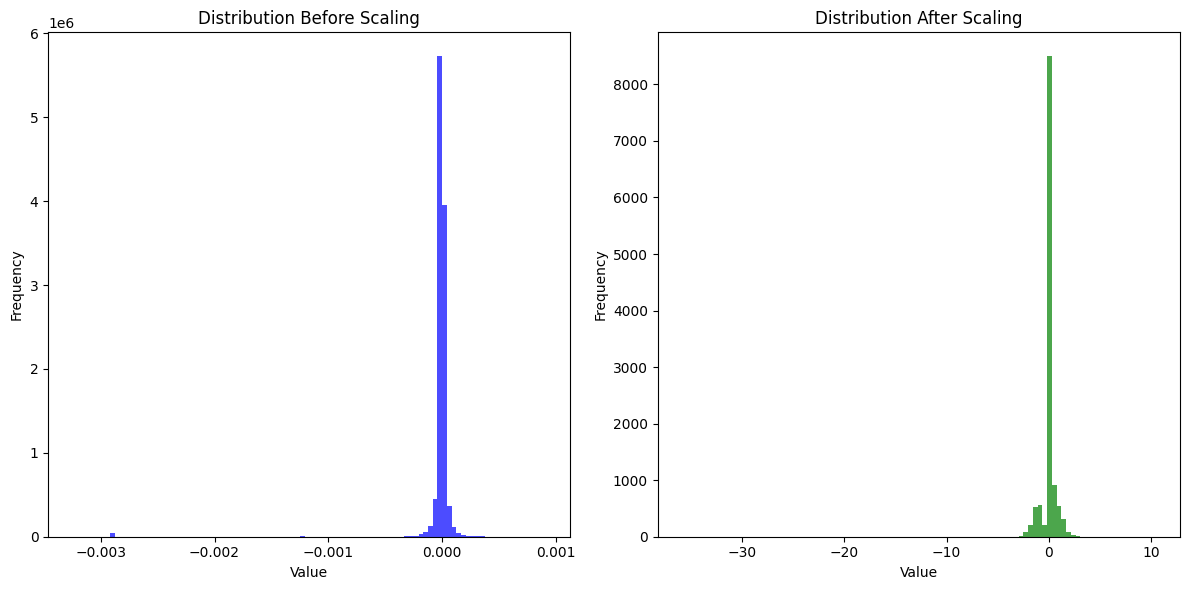

In [27]:
# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(flattened_before, bins=100, color='blue', alpha=0.7)
plt.title('Distribution Before Scaling')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_after, bins=100, color='green', alpha=0.7)
plt.title('Distribution After Scaling')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The original range of values was already small, so the effect of scaling worked as intended, rescaling the data to have a mean of 0 and standard deviation of 1, improving numerical stability for downstream processes. 

### Balance number of samples per label

If we take a look at the EEG labels classes we can find that we have a disproportioned quantity of samples that could lead to overfit during training:

In [28]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}

def print_label_distribution(dataset):
    temp_labels = pd.Series([y for _, y in dataset]).map(classes_mapping)
    ax = temp_labels.value_counts().plot(kind='barh')
    ax.set_xlabel('Number of examples')
    ax.set_ylabel('Sleep stage')

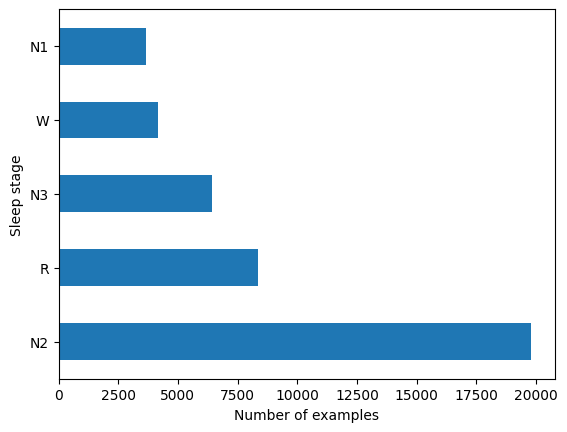

In [29]:
print_label_distribution(dataset)

We have a very large number of samples at our disposal so in order to prevent overfitting on some class that are clearly oversampled we decide we could compute some class weight to assign to each learning algorithm we will use. 

This method was chosen as it is a pretty common regularization technique and it is also very easy to compute

In [30]:
_y = np.concatenate([np.atleast_1d(y) for _, y in dataset])
class_weights = compute_class_weight('balanced', classes=np.unique(_y), y=_y)
dictionary_class_weights = {i: value for i, value in enumerate(class_weights)}
print(class_weights)

[2.03957631 2.31929921 0.42809358 1.32071707 1.01478021]


### Check shapes discrepancy

Before going forward, in order to prevent any errors, we need to take a look at the number of samples inside each epoch. This is done because in previous versions there was a screw up while loading the data and While running some code it was noticed that the number of samples inside each epoch are inconsistent (Meanwhile, number of channels was always the same)

Therefore we just this step as to make sure we did not mess the dimension of the data during previous elabotation

In [31]:
def plot_uniformity(dataset):

    eeg_epochs = [epoch for epoch,_ in dataset]

    # Extract dimensions from the epochs
    num_samples_per_epoch = [epoch.shape[0] for epoch in eeg_epochs]  # shape[0]
    num_channels = [epoch.shape[1] for epoch in eeg_epochs]           # shape[2]
    time_length = [epoch.shape[2] for epoch in eeg_epochs]            # shape[1]

    # Check uniformity
    unique_samples = np.unique(num_samples_per_epoch)
    unique_channels = np.unique(num_channels)
    unique_time_length = np.unique(time_length) 

    # Create subplots in a horizontal line
    plt.figure(figsize=(18, 6))

    # Plot for shape[0] (number of samples)
    plt.subplot(1, 3, 1)
    plt.plot(num_samples_per_epoch, 'ro-', label='Number of epochs (shape[0])', markersize=6)
    if len(unique_samples) == 1:
        plt.axhline(y=unique_samples[0], color='r', linestyle='--', label=f'Uniform: {unique_samples[0]}')
    plt.xlabel('Epoch Index')
    plt.ylabel('Samples')
    plt.title('Number of Samples per Epoch (shape[0])')
    plt.grid(True)
    plt.legend()

    # Plot for shape[1] (number of channels)
    plt.subplot(1, 3, 2)
    plt.plot(num_channels, 'g^', label='Number of Channels (shape[1])', markersize=8)
    if len(unique_channels) == 1:
        plt.axhline(y=unique_channels[0], color='g', linestyle='--', label=f'Uniform: {unique_channels[0]}')
    plt.xlabel('Epoch Index')
    plt.ylabel('Channels')
    plt.title('Number of Channels per Epoch (shape[1])')
    plt.grid(True)
    plt.legend()

    # Plot for shape[2] (time length)
    plt.subplot(1, 3, 3)
    plt.plot(time_length, 'bo-', label='Time Length (shape[2])', markersize=6)
    if len(unique_time_length) == 1:
        plt.axhline(y=unique_time_length[0], color='b', linestyle='--', label=f'Uniform: {unique_time_length[0]}')
    plt.xlabel('Epoch Index')
    plt.ylabel('Time Length')
    plt.title('Time Length per Epoch (shape[2])')
    plt.grid(True)
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

Below is a graph that demonstrates how (after fixes) the number of samples changes in each epoch is the same:

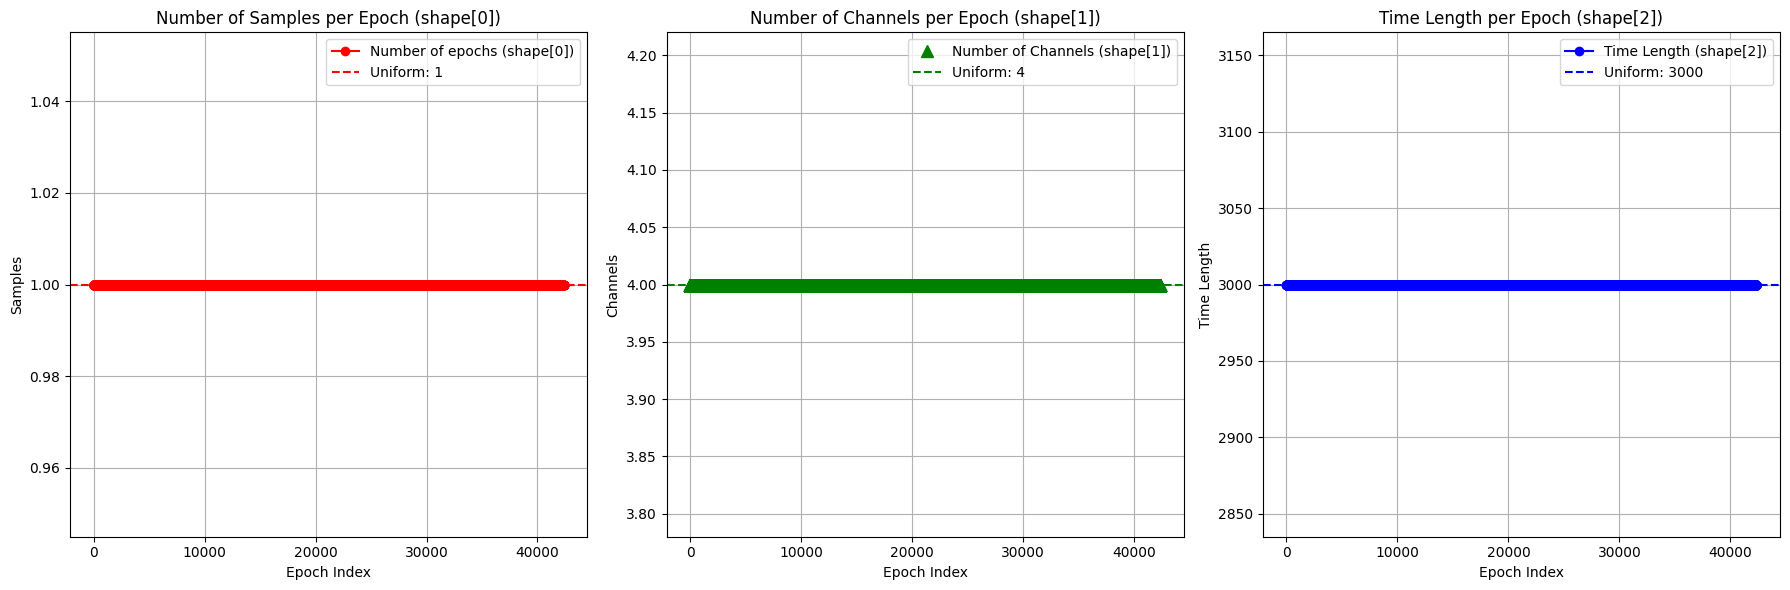

In [32]:
plot_uniformity(dataset=dataset)

### Unload unnecessary variables

And, since the shape is now uniform across all epochs, we can define new function to unload variavles we don't need anymore. (We do this to preserve ram on our machine)

In [33]:
def unload_variables(var_names):
    for var_name in var_names:
        if var_name in globals():
            del globals()[var_name]

We will use this to delete previously used `balanced_epoch` variable as it is not needed anymore

In [34]:
unload_variables(['raws', 'eeg_epochs', 'eeg_epochs_subj_ninght', 'labels', 'all_datasets'])

## Step 3: Split into Train, Validation, and Test Sets

In order to split the data into train / test and validation set we define a dataloader function, much like in lab session, this will be also used to call different types of feature extractor, and then, train the network

Also while defining this function we kind, of cheat: 
- we use night-1 of each subject (as train) and then try to predict the night-2 of those same person (use night-2 as test set). This should help our prediction as it is quite likely that the same person would register similiraties in sleep patterns in two consecutive nights. 
- then we split test data into validation and test set by:
    - first half of subects: test set
    - second half of subjects validation set

In [35]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [36]:
def train_test_val_split(dataset):
    # Use recording 1 of subjects 0-22 as test set
    subj_rec_nbs = [(subj_nb, rec_nb)  
                for subj_nb, rec_nb in zip(range(25), [1] * 25)]
    # up to 25 as we have 22 subjects (1 to 24) but we skip 0, 3, and 23
    subj_rec_nbs.remove((0, 1))
    subj_rec_nbs.remove((3, 1))
    subj_rec_nbs.remove((23, 1))

    # Pick recordings using subject and recording numbers.
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)

    # Split the dataset into training and test sets by recording night 
    # night 1 = train
    # night 2 = test          
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    train_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        test_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        test_ds = None
    
    # Split test samples by subjects 
    # in this way we split between validation and test set
    n_subjects_valid = max(1, int(len(test_ds.datasets) * 0.5)) 
    groups = [getattr(ds, 'subj_nb') for ds in test_ds.datasets]
    test_idx, valid_idx = next(
        LeavePGroupsOut(n_subjects_valid).split(X=groups, groups=groups))

    test_ds = ConcatDataset([test_ds.datasets[i] for i in test_idx])
    valid_ds = ConcatDataset([test_ds.datasets[i] for i in valid_idx])

    return train_ds, test_ds, valid_ds 

In [37]:
train_ds, test_ds, valid_ds = train_test_val_split(dataset)
print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Test: {len(test_ds)}')
print(f'Validation: {len(valid_ds)}')

Number of examples in each set:
Training: 21318
Test: 10413
Validation: 10413


In [38]:
# find shape of each dataset
print('Shape of each sample of dataset:')
print(f'Training: {train_ds[0][0].shape}')
print(f'Test: {test_ds[0][0].shape}')
print(f'Validation: {valid_ds[0][0].shape}')

Shape of each sample of dataset:
Training: torch.Size([1, 4, 3000])
Test: torch.Size([1, 4, 3000])
Validation: torch.Size([1, 4, 3000])


## Step 4: Feature extraction and learning models

### Attempt 1: Time-Domain Features

In this step we extract some time-domain features (similarly to what we did in the first lecture with sound). These basic statistical features help capture the overall activity levels and variability in the EEG signal, which can vary significantly across different sleep stages and then try classify the samples based on those features

#### Feature extraction

First we define a feature extraction function, this will extract for each EEG signal:
- mean value
- variance
- stardard deviatiation
- energy (rms)

and then concatenates all of those.

In [39]:
def time_domain_features_extractor(X): 
    mean = np.mean(X, axis=-1)              # Mean along time axis
    variance = np.var(X, axis=-1)           # Variance along time axis
    std_dev = np.std(X, axis=-1)            # Standard deviation along time axis
    rms = np.sqrt(np.mean(X**2, axis=-1))   # Root mean square
    
    # Combine features into a single feature vector
    features = np.hstack([mean, variance, std_dev, rms])
    return features

Then we define a dataloader function that applies feature extraction for each sample, then returns in output a touple of: (exrtacted_features, labels)


In [40]:
def data_loader_Time_Domain_features(pytorch_dataset):
    data = []
    labels = []
    for i in range(len(pytorch_dataset)):
        X, y = pytorch_dataset[i]
        data.append(time_domain_features_extractor(X.numpy().squeeze()))
        labels.append(y)
    return  np.array(data), np.array(labels)

In [41]:
# Convert the train, validation, and test datasets
train_X, train_y = data_loader_Time_Domain_features(train_ds)
valid_X, valid_y = data_loader_Time_Domain_features(valid_ds)
test_X, test_y = data_loader_Time_Domain_features(test_ds)

# Check the shapes to ensure they are correct
print("Train Data Shape:", train_X.shape, "Train Labels Shape:", train_y.shape)
print("Validation Data Shape:", valid_X.shape, "Validation Labels Shape:", valid_y.shape)
print("Test Data Shape:", test_X.shape, "Test Labels Shape:", test_y.shape)

Train Data Shape: (21318, 16) Train Labels Shape: (21318,)
Validation Data Shape: (10413, 16) Validation Labels Shape: (10413,)
Test Data Shape: (10413, 16) Test Labels Shape: (10413,)


#### Model definition and training

A simple SVM model is trained. Please note that we do not expect to get great performance from this attempt as the feature we are extracting are very general and have very little to none correlation to the target. Considering also we are using a very simple model like SVM we expect bad classication performances:

In [42]:
# SVM initialization and training
clf = SVC(kernel='rbf', class_weight=dictionary_class_weights)
clf = clf.fit(train_X, train_y)

#### Evaluate results

Validation Accuracy: 7.60%
Test Accuracy: 7.60%
Classification report:
              precision    recall  f1-score   support

           0       0.08      1.00      0.14       791
           1       0.00      0.00      0.00       959
           2       0.00      0.00      0.00      5140
           3       0.00      0.00      0.00      1459
           4       0.00      0.00      0.00      2064

    accuracy                           0.08     10413
   macro avg       0.02      0.20      0.03     10413
weighted avg       0.01      0.08      0.01     10413

confusion matrix


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

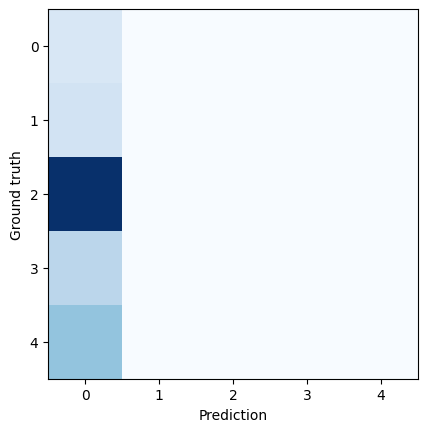

In [43]:
# SVM inference
test_pred = clf.predict(test_X)
valid_pred = clf.predict(valid_X)  # Predicted labels for validation set

# Evaluate accuracy
valid_accuracy = accuracy_score(valid_y, valid_pred)
test_accuracy = accuracy_score(test_y, test_pred)
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print('Classification report:')
print(classification_report(test_y, test_pred))

# confusion matrix
print('confusion matrix')
cm = confusion_matrix(test_y, test_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

As we can see we reach very poor performance, this was an expected result as classifyin sleep stages is a very diffult task; it was very clear from the start that just by extracting some time-domain features (that could be correlated to any kind of singal) would have been simply not suffient to classify the data. 

This bad performances are also due to the fact that we are using a very siple model as SVM to trying to do this very difficult classification task. 

### Attempt 2: Frequency-domain features

In this step we extract some frequency-domain features. These kinds of feature are helpful to reveal spectral composition associated with physiological states.

#### Feature extraction

First (just as before) we define a feature extraction function. This function will extract key metrics like Power Spectral Density (PSD), Band Power:

- **Power Spectral Density (PSD)**: This is because different sleep stages are associated with distinct frequency bands. For example:
    - Delta (0.5-4 Hz): Deep sleep (NREM stages 3-4).
    - Theta (4-8 Hz): Light sleep (NREM stage 1).
    - Alpha (8-13 Hz): Relaxation, often decreases during sleep.
    - Beta (13-30 Hz): Wakefulness or REM sleep.

- **Spectral Entropy**: Indicates the regularity and complexity of the signal in the frequency domain, with lower values during deep sleep stages.

Therefore we could expect big increase in performance by using this kind of features as they are deeply correlated to sleep stages

In [44]:
# Define frequency bands (Hz)
FREQ_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
}

# Feature extraction function for frequency domain
def frequency_domain_features_extractor(X, sfreq=100):
    # Compute Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(X, sfreq, nperseg=sfreq)

    # Band Power: Compute power for each frequency band
    band_powers = []
    for band, (low, high) in FREQ_BANDS.items():
        idx_band = (freqs >= low) & (freqs <= high)
        band_power = np.sum(psd[:, idx_band], axis=1)  # Sum power in band
        band_powers.append(band_power)

    # Spectral Entropy: Compute Shannon entropy of the normalized PSD
    psd_normalized = psd / np.sum(psd, axis=1, keepdims=True)  # Normalize PSD
    spectral_entropy = -np.sum(psd_normalized * np.log(psd_normalized + 1e-10), axis=1)

    # Combine features (flatten band powers and append entropy)
    features = np.hstack([np.array(band_powers).flatten(), spectral_entropy])
    return features

Then the dataloader:

In [45]:
def data_loader_Frequency_Domain_features(pytorch_dataset):
    data = []
    labels = []
    for i in range(len(pytorch_dataset)):
        X, y = pytorch_dataset[i]
        data.append(frequency_domain_features_extractor(X.numpy().squeeze(), sfreq=sfreq))
        labels.append(y)
    return  np.array(data), np.array(labels)

In [46]:
# Convert the train, validation, and test datasets
train_X, train_y = data_loader_Frequency_Domain_features(train_ds)
valid_X, valid_y = data_loader_Frequency_Domain_features(valid_ds)
test_X, test_y = data_loader_Frequency_Domain_features(test_ds)

# Check the shapes to ensure they are correct
print("Train Data Shape:", train_X.shape, "Train Labels Shape:", train_y.shape)
print("Validation Data Shape:", valid_X.shape, "Validation Labels Shape:", valid_y.shape)
print("Test Data Shape:", test_X.shape, "Test Labels Shape:", test_y.shape)

Train Data Shape: (21318, 20) Train Labels Shape: (21318,)
Validation Data Shape: (10413, 20) Validation Labels Shape: (10413,)
Test Data Shape: (10413, 20) Test Labels Shape: (10413,)


#### Model definintion and training

We use same model as before to measure difference:

In [47]:
# SVM initialization and training
clf = SVC(kernel='rbf', class_weight=dictionary_class_weights)
clf = clf.fit(train_X, train_y)

#### Evaluate results

Validation Accuracy: 72.27%
Test Accuracy: 72.27%
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       791
           1       0.41      0.47      0.44       959
           2       0.88      0.69      0.78      5140
           3       0.60      0.90      0.72      1459
           4       0.72      0.77      0.74      2064

    accuracy                           0.72     10413
   macro avg       0.66      0.72      0.68     10413
weighted avg       0.75      0.72      0.73     10413

confusion matrix


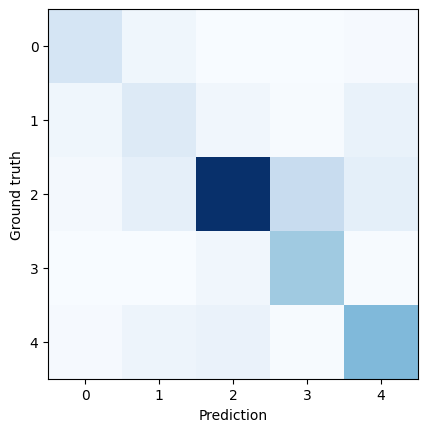

In [48]:
# SVM inference
test_pred = clf.predict(test_X)
valid_pred = clf.predict(valid_X)  # Predicted labels for validation set

# Evaluate accuracy
valid_accuracy = accuracy_score(valid_y, valid_pred)
test_accuracy = accuracy_score(test_y, test_pred)
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print('Classification report:')
print(classification_report(test_y, test_pred))

# confusion matrix
print('confusion matrix')
cm = confusion_matrix(test_y, test_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

We can now see a HUGE jump in performace, we are able to classify this hard problem whit just a very simple model and having more than 70% certainty.  

We also reach average of more than 70% in f1 score wich is a very good indicator of when we have un unbalanced dataset like in our case.

From confusion matrix alone we can clearly see that the one class we are able to predict most confidently is the class 2, wich makes perfect sense as it is the one whit most samples and it also make sense that class 2 and 3 are the following most precise as Spectral Entropy might help classify those the most. 

This results alone prove this problem can be solved even by a simple model like SVM; let's now see in next attempt if we can increase those performances

### Attempt 3: Combine time and frequencies domain

We previously saw that with frequency domain features we get great accuracy values. We now want to add to those features the one extracted in attempt 1 to see if we can improve accuracy by simply adding this information to the mix. Kindof like adding missing pieces to a puzzle to get a better frame of the picture

#### Feature extraction

Merging both feature extractions into one:

In [49]:
# Combine all features into one function
def combine_features_extractor(X, sfreq=100):
    
    frequency_features = frequency_domain_features_extractor(X,sfreq=sfreq)

    time_features = time_domain_features_extractor(X)

    return np.hstack([frequency_features, time_features])

Calling new feature extractor in dataloader:

In [50]:
# Function to process dataset and extract nonlinear features
def data_loader_combined_features(dataset):
    features = []
    labels = []
    
    for X, y in dataset:
        features.append(combine_features_extractor(X.numpy().squeeze())) 
        labels.append(y)  # Append label
    
    return np.array(features), np.array(labels)

In [51]:
# Convert the train, validation, and test datasets
train_X, train_y = data_loader_combined_features(train_ds)
valid_X, valid_y = data_loader_combined_features(valid_ds)
test_X, test_y = data_loader_combined_features(test_ds)

# Check the shapes to ensure they are correct
print("Train Data Shape:", train_X.shape, "Train Labels Shape:", train_y.shape)
print("Validation Data Shape:", valid_X.shape, "Validation Labels Shape:", valid_y.shape)
print("Test Data Shape:", test_X.shape, "Test Labels Shape:", test_y.shape)

Train Data Shape: (21318, 36) Train Labels Shape: (21318,)
Validation Data Shape: (10413, 36) Validation Labels Shape: (10413,)
Test Data Shape: (10413, 36) Test Labels Shape: (10413,)


#### Model definintion and training

Also using same model as before to measure differences:

In [52]:
# Train SVM with all features
clf = SVC(kernel='rbf', class_weight=dictionary_class_weights)
clf.fit(train_X, train_y)

SVC(class_weight={0: np.float64(2.0395763119884447),
                  1: np.float64(2.319299206131946),
                  2: np.float64(0.4280935778889394),
                  3: np.float64(1.3207170693686672),
                  4: np.float64(1.0147802131991854)})

#### Evaluate results

Validation Accuracy: 72.25%
Test Accuracy: 72.25%
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       791
           1       0.42      0.46      0.44       959
           2       0.88      0.69      0.77      5140
           3       0.60      0.90      0.72      1459
           4       0.71      0.78      0.74      2064

    accuracy                           0.72     10413
   macro avg       0.66      0.72      0.68     10413
weighted avg       0.75      0.72      0.73     10413

Confusion matrix:


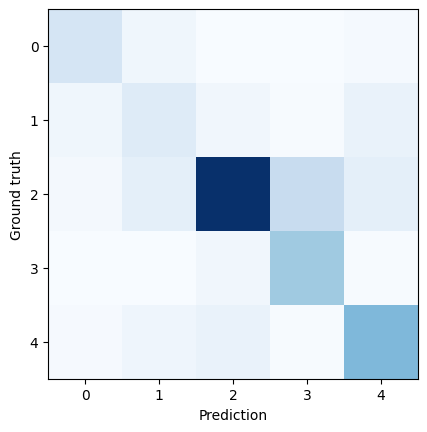

In [53]:
# SVM inference
test_pred = clf.predict(test_X)
valid_pred = clf.predict(valid_X)  # Predicted labels for validation set

# Evaluate accuracy
valid_accuracy = accuracy_score(valid_y, valid_pred)
test_accuracy = accuracy_score(test_y, test_pred)
print(f"Validation Accuracy: {valid_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print('Classification report:')
print(classification_report(test_y, test_pred))

# confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(test_y, test_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

As we can see here performance very so slightly decreased (by 0.02%). This could possibly mean 2 things: 
1. that SVM alghoritm pretty much completly ignore the addiction of the time-domain features (wich is most likely hypotesis as SVM tends to learn pretty much only on most significant features)
2. that the addiction of other features actully helped the model to generalize more. This might result in a decrease in train but, in our case, also test and validation accuracy. This is because our test and validation samples are sleep EGGs samples of the exact same people used to train the model wich means there might be very similiar patterns in extracted features between train / test / validation dataset. Consequentially this means the model could have simply learned the sleep patterns of our specific 10 patiesnts, instead of generalizing sleep patterns. Then, adding time-domain features might have helped the model generalize a bit more as the time-domain features are much more general to all signal samples; this, of course (for resons talked above), might have lead to decrease in accurary but could have potentially lead to better classification of other sleep EEG samples of other people. Unfortunatly we do not dispose the data to verify this hypotesis

#### Save model to file

In [54]:
import joblib

# Save the trained model to a file
joblib.dump(clf, 'svm_sleep_stage_classifier.pkl')

['svm_sleep_stage_classifier.pkl']

### Attempt 4: Try using RNN

As we saw in theoretical lectures, Recursive Neural Networks (RNN) are designed to process sequential data. This means they could be very useful in our usecase as all of our sleep stages samples are non-other that sequential data. Also we could benefit knowing previous sleep stages to classify current one; wich means that, on paper, RNN should be very good on this task.

! **IMPORTANT NOTE** !
In this case we are not using extracted features! Extracted features already simplify and summarize the EEG signals. Using an RNN on these features may not fully exploit its strengths (direct application of RNNs to raw EEG signals might yield better results in some cases).


Let's see how it performs:

#### Feature extraction

First we definie our feature extraction function, this is non-other than an identity feature extraction function that also converts a PyTorch Dataset to a Keras-compatible format.

In [55]:
def data_loader_RNN(pytorch_dataset):
    data = []
    labels = []
    for i in range(len(pytorch_dataset)):
        X, y = pytorch_dataset[i]
        data.append(X.numpy().squeeze(0))  # Remove the additional dimension
        labels.append(y)
    return  np.transpose(np.array(data), (0, 2, 1)), np.array(labels)

In [56]:
# Convert the train, validation, and test datasets
train_X, train_y = data_loader_RNN(train_ds)
valid_X, valid_y = data_loader_RNN(valid_ds)
test_X, test_y = data_loader_RNN(test_ds)

# Check the shapes to ensure they are correct
print("Train Data Shape:", train_X.shape, "Train Labels Shape:", train_y.shape)
print("Validation Data Shape:", valid_X.shape, "Validation Labels Shape:", valid_y.shape)
print("Test Data Shape:", test_X.shape, "Test Labels Shape:", test_y.shape)

Train Data Shape: (21318, 3000, 4) Train Labels Shape: (21318,)
Validation Data Shape: (10413, 3000, 4) Validation Labels Shape: (10413,)
Test Data Shape: (10413, 3000, 4) Test Labels Shape: (10413,)


#### Define the RNN

In [57]:
# Define input shape and number of classes
input_shape = train_X.shape[1:]  # (timesteps, features)
num_classes = len(np.unique(train_y))

model = Sequential([
    LSTM(64, input_shape=input_shape, return_sequences=True),
    Dropout(0.05),
    LSTM(32),  # Second LSTM layer
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3000, 64)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,301 (122.27 KB)

 Trainable params: 31,301 (122.27 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### Model training

We could expect good results from the network, but...

In [63]:
skip_training = True

In [ ]:
if(skip_training == False):
    import time
    start_time = time.time()

    # Train the model
    history = model.fit(
        train_X, train_y,
        validation_data=(valid_X, valid_y),
        epochs=20,
        batch_size=4092,
        callbacks=[early_stopping],
        class_weight=dictionary_class_weights
    )

    # Record the end time
    end_time = time.time()

    # Calculate the training duration
    training_time = end_time - start_time

Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2563s 15s/step - accuracy: 0.1903 - loss: 1.6107 - val_accuracy: 0.1653 - val_loss: 1.6057
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2516s 15s/step - accuracy: 0.2145 - loss: 1.5893 - val_accuracy: 0.1716 - val_loss: 1.5944
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2545s 15s/step - accuracy: 0.1974 - loss: 1.5950 - val_accuracy: 0.1446 - val_loss: 1.6034
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2551s 15s/step - accuracy: 0.1683 - loss: 1.6071 - val_accuracy: 0.1548 - val_loss: 1.6027
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2569s 15s/step - accuracy: 0.1895 - loss: 1.6035 - val_accuracy: 0.2745 - val_loss: 1.5326
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2601s 16s/step - accuracy: 0.2452 - loss: 1.5567 - val_accuracy: 0.2003 - val_loss: 1.5688
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2583s 15s/step - accuracy: 0.2249 - loss: 1.5355 - val_accuracy: 0.1729 - val_loss: 1.4992
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2572s 15s/step - accuracy: 0.2332 - loss: 1

As we can see training time took an absurd amount of time (12 hrs 57 min), as out dataset is vey big, and we only took 128 as our batch size (wich should have defineatly been higher to accelerate training)

#### Results evaluation

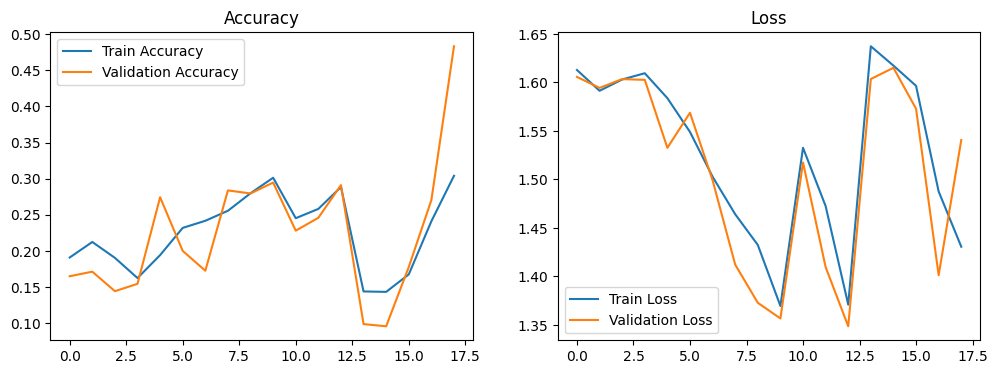

In [ ]:
if(skip_training == False):

    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

The RNN model performed poorly, with accuracy and loss graphs showing no clear learning curve. Fluctuations in validation accuracy and loss suggest the model failed to learn meaningful patterns.  

Comparing this to the SVM, which achieved 70% accuracy using frequency-domain features, highlights the importance of feature engineering. Frequency-based features capture key physiological patterns, making classification easier for SVMs, which work well with structured, low-dimensional data. In contrast, the RNN struggled with raw EEG data, likely due to its high dimensionality and the need for more data and computational power. This reinforces the advantage of domain-specific feature extraction.

In [ ]:
if(skip_training == False):
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(test_X, test_y)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

326/326 ━━━━━━━━━━━━━━━━━━━━ 170s 522ms/step - accuracy: 0.3191 - loss: 1.3381
Test Loss: 1.3486343622207642, Test Accuracy: 0.2911745011806488


In fact while trying to print accuracy on test set we can clearly see that performance are very underwhelming when compared to previous SVM models, we even skip printing classification report and confusion matrix as those would be pointless

#### Save the model

We choose not to save the model for this instance as it din't provide any meaningful results

### Attempt 5: Chambon et al

If we wanna go a step further in order to actully get any good results we will have to use a networw made ad-hoc for sleep stage classification. After a quick research it emerged that one network that could help us achive our goal is the sleep staging architecture of Chambon et al. (2018) (adapted from Banville et al. 2020) wich is a specilized CNN created to classify raw EEG signals.

#### Feature extraction

Once again, for this model no real feature extraction is needed. We just need to instantiate the pytorch `DataLoader` (as a pytorch object) that wraps the dataset and makes it easy to obtain batches of examples to feed to our neural network. Therefore this funcion does nothing else than return `identity(ds)` feature extraction of each dataset but sub-divided into batches.

In [67]:
def data_loader_CNN(train_ds, valid_ds, test_ds,
                          train_batch_size = 128, 
                          valid_batch_size = 256 ):    
    num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

    loader_train = DataLoader(
        train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = DataLoader(
        valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
    loader_test = DataLoader(
        test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
    
    return loader_train, loader_valid, loader_test

In [68]:
train_loader, valid_loader, test_loader = data_loader_CNN(train_ds, valid_ds, test_ds)

#### Define the CNN

In [69]:
class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

This is a convolutional neural network (made using pytorch library) where:
- The **input**:

    is a 30-s window of `C` channels. By default we have set `C` to 4 by selecting the previously analyzed available EEG channels in Sleep Physionet during phase 1.

<br>

- The **hidden layers**: 
    
    there is a succession of convolutional layers, max pooling, and nonlinearities (Relu). The feature maps are finally flattened and passed through a fully-connected layer.

<br>

- The **output**
    
    is a 5-dimensional vector where each dimension is matched to one of our 5 classes (Wake, N1, N2, N3 and REM sleep stages).



In [70]:
# instantiating the model
model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)

Then we have the **optimizer** and the **loss function**. Those are two essential components of the training process:

- The **optimizer**: In this case, we utilize `Adam`, a widely used adaptive gradient descent optimizer designed for deep neural networks.  
- The **loss function**: For this purpose, we use the standard multiclass cross-entropy loss.  

In [71]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
loss_function = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

#### Model training

Next, we are gonna write some functions to carry on training. Both of these functions will be called each training epoch and will esentially evaluate loss and 'metric' for training and validation, where 'metric' is a parameter.

This means we can dinamically change our metric to be anything (from accuracy, to f1-score, and so on..)

In [72]:
# Trains the given model for one epoch using the provided data
def _do_train(model, loader, optimizer, loss_function, device, metric):
    # training loop
    model.train()
    
    # Initialize variables to store the loss and performance
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()

    # Iterate over the batches
    for idx_batch, (batch_x, batch_y) in enumerate(loader):

        # initialize variables to compute loss
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        # loss calculation
        output = model(batch_x)
        loss = loss_function(output, batch_y)

        # apply backpropagation
        loss.backward()
        optimizer.step()
        
        # collect the model's predicted class indices and true labels for each batch
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        # records the loss value for the current batch in a train_loss array or list
        train_loss[idx_batch] = loss.item()
    
    # Compute the performance metric
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf

In [73]:
def _validate(model, loader, loss_function, device, metric):
    # validation loop
    model.eval()
    
    # Initialize variables to store the loss and performance
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()

    # Iterate over the batches
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):

            # initialize variables to compute loss
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            # loss calculation
            loss = loss_function(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            # collect the model's predicted class indices and true labels for each batch
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    # Compute the performance metric    
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf

Next function is the one tha will use both previous functions in a loop to defy each epoch of train:

In [74]:
def train(model, loader_train, loader_valid, optimizer, loss_function, n_epochs, 
          patience, device, metric=None):
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
    
    # pretty print each metric
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    # training (+validation) loop
    for epoch in range(1, n_epochs + 1):
        # train the model + backpropagation
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, loss_function, device, metric=metric)
        
        # validate the model
        valid_loss, valid_perf = _validate(
            model, loader_valid, loss_function, device, metric=metric)
        
        # add performance to hystory
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

Once everything is settep up can proceed with training the network:

In [75]:
n_epochs = 20
patience = 5

best_model, history = train(
    model, train_loader, valid_loader, optimizer, loss_function, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.0421 	 0.8163 	 0.3886 	 0.4914
best val loss inf -> 0.8163
2 	 0.7290 	 0.7934 	 0.5626 	 0.5650
best val loss 0.8163 -> 0.7934
3 	 0.6723 	 0.7587 	 0.6086 	 0.5489
best val loss 0.7934 -> 0.7587
4 	 0.6316 	 0.7154 	 0.6352 	 0.6271
best val loss 0.7587 -> 0.7154
5 	 0.6169 	 0.7079 	 0.6447 	 0.6102
best val loss 0.7154 -> 0.7079
6 	 0.5902 	 0.7097 	 0.6624 	 0.6174
7 	 0.5746 	 0.7064 	 0.6726 	 0.6284
best val loss 0.7079 -> 0.7064
8 	 0.5542 	 0.7085 	 0.6890 	 0.5989
9 	 0.5462 	 0.6755 	 0.6911 	 0.6644
best val loss 0.7064 -> 0.6755
10 	 0.5329 	 0.6912 	 0.6974 	 0.6848
11 	 0.5294 	 0.6906 	 0.6987 	 0.6452
12 	 0.5106 	 0.6960 	 0.7078 	 0.6088
13 	 0.5055 	 0.6653 	 0.7119 	 0.6590
best val loss 0.6755 -> 0.6653
14 	 0.4908 	 0.6541 	 0.7225 	 0.6694
best val loss 0.6653 -> 0.6541
15 	 0.4836 	 0.6579 	 0.7269 	 0.6802
16 	 0.4821 	 0.6508 	

Plese note that here during training, instead of accuracy we print **Cohen's kappa**. This score is a statistical measure of inter-rater agreement or inter-annotator agreement for qualitative (categorical) data. It is commonly used to evaluate the performance of classification models, especially in cases where the classes are imbalanced.

#### Results evaluation

First thing we do, is evaluate the loss and Cohen's kappa in all training epochs by analyzing if the curves seem good enough: 

Text(0, 0.5, "Cohen's kappa")

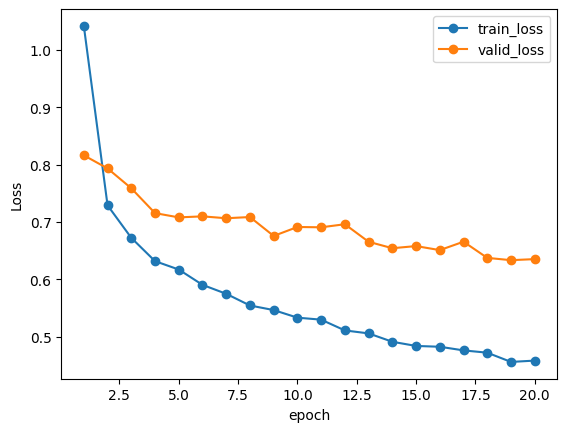

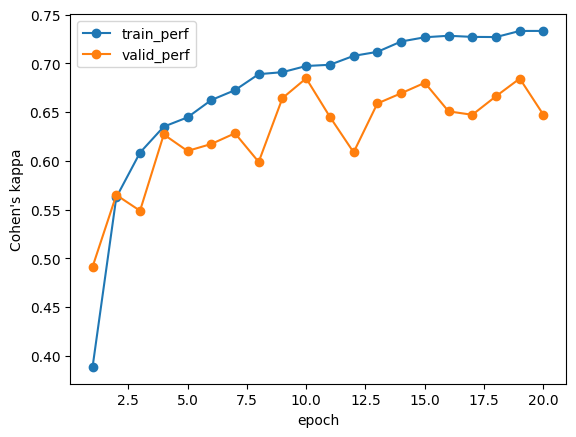

In [76]:
# Visualizing the learning curves
history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

And indeed it seems that over all each epoch we are able to diminish loss and increase Cohen's kappa pretty stedily. Those are good indicies to the fact that the training we did finally achived good results. Also, since the curves of trianing and validation are not that far apart we can deduce that there is not much overfitting on the data and the network is an actual good classifier.

Please also take note that it is quite normal for Cohen's kappa to flunctuating like that as long as overall it keeps getting bigger in both train and validation. This behaviour is simply due to how the metric is calculated, wich brings it to be less steady than accuracy.

Then we can proceed by using the trained model and evalueate if we achive good accuracy results while predicting test data (and since we saw earlier that we should't have much overfit we would expect good results):

In [77]:
# Compute test performance
best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in test_loader:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.780
Test Cohen's kappa: 0.647


It seems that using this specifically engineered network we can finally reach good results in reasonable times, as training the network only took 20 minutes and we finally reach a good accuracy of more than 70%; actually close to 80% wich are fenomenal results.

In [78]:
def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()
    
    return fig, ax

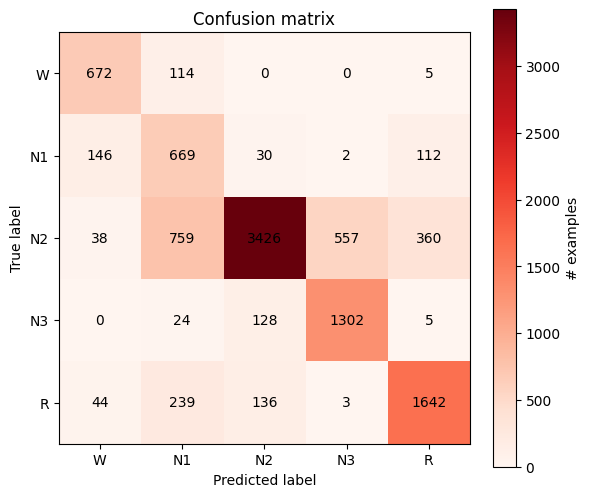

In [79]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

If we plot confusion matrix we can actully see it being MUCH similiar to the one we obtained in attempt 2 and 3 when extracting frequency-domain features. In fact we have:
- N2 class (the oversampled one) to be the most precise
- classes below N2 to be second best with pretty close number of true positive
- classes above N2 to to be harder to recognize

Wich are exact same observation we made on attempt 2 and 3.

#### Saving the model

In [80]:
torch.save(model.state_dict(), 'sleep_stager_chambon2018.pth')

## Step 5: Conclusions

In order to further confirm similarities between attempt-3 and attempt-5 we can also visualize the prediction hypnogram for the evolution of sleep stages across an overnight recording:

In [81]:
sample_idx = 0
stages = ["Wake", "NREM1", "NREM2", "NREM3", "REM"]

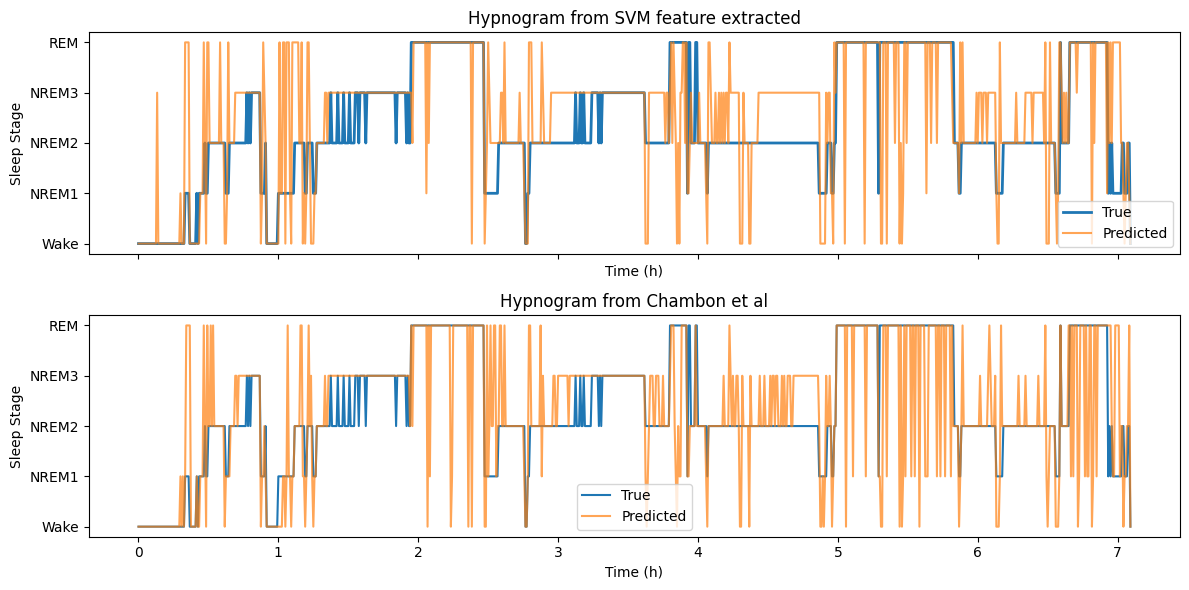

In [82]:
# Create a figure with two subplots (one above the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot 1: Hypnogram from SVM feature extracted
valid_X, valid_y = data_loader_combined_features(valid_ds)
predicted_y = clf.predict(valid_X)
# Create mask for the chosen recording ID
mask = rec_ids == sample_idx
# Create time axis (convert to hours)
t = np.arange(len(valid_y[mask])) * 30 / 3600
# Plot on the first axis
axes[0].plot(t, valid_y[mask], label='True', lw=2)
axes[0].plot(t, predicted_y[mask], alpha=0.7, label='Predicted', lw=1.5)
axes[0].set_yticks([0, 1, 2, 3, 4])
axes[0].set_yticklabels(stages)
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('Sleep Stage')
axes[0].set_title(f'Hypnogram from SVM feature extracted')
axes[0].legend()

# Plot 2: Hypnogram for one recording from Chambon et al
t = np.arange(len(y_true[mask])) * 30 / 3600
# Plot on the second axis
axes[1].plot(t, y_true[mask], label='True')
axes[1].plot(t, y_pred[mask], alpha=0.7, label='Predicted')
axes[1].set_yticks([0, 1, 2, 3, 4])
axes[1].set_yticklabels(stages)
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('Sleep Stage')
axes[1].set_title('Hypnogram from Chambon et al')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Here we can see hypnograms generated by the both models demonstrates reasonable alignment with the true sleep stages (as we could have guessed by good accuracy results). As we can see both plots look a lot alike, wich further confirm out hypotesis of reaching very similiar classifiers in both attempts. Some of the main differences are:
- SVM model tends to be more precise while classifying REM sleep than Chambon et al; wich makes sense as it should be one of the easyest sleep stages to classify using Power Spectral density
- Chambon et al tends to be more precise when classifying 'wake' sleep stages; wich makes sense again as wakefulness is often characterized by distinct high-frequency brain activity and when we did feature extraction we specifed we didn't add much to classify high frequencies

**Conclusions:**  
By presenting these results, we have demonstrated that with effective feature extraction, even a simple algorithm like SVM can achieve comparable classification performance to highly specialized models, such as Chambon et al.'s approach, which is specifically engineered for sleep classification. This highlights the power of domain knowledge in guiding feature engineering, as well as the efficiency gains that can be achieved by leveraging simpler, classical machine learning techniques.  

One of the key advantages of this approach is the significant reduction in computational cost and training time. Specifically:  
- **Efficiency of Simpler Models**: Using a simple model like SVM with manually extracted features required only 1-2 seconds in total for feature extraction and training. This makes it highly practical for resource-constrained settings where computational power or time is limited.  
- **Higher Computational Costs for End-to-End Models**: Although Chambon et al.'s model eliminates the need for manual feature extraction and works directly with raw data, it required approximately 20 minutes to train. This significant time difference stems from the complexity of deep learning architectures, which rely on iterative optimization and the processing of raw, high-dimensional data.  

These findings highlight a crucial trade-off: while deep learning models like Chambon et al.'s are powerful and capable of directly extracting features from raw data, they demand more computational resources and time. On the other hand, classical models, when combined with carefully crafted feature engineering, can deliver competitive performance with minimal resource requirements.  

This has practical implications for real-world applications:  
- For tasks requiring rapid prototyping or deployment in low-resource environments, feature-based classical models are highly advantageous.  
- For high-stakes or large-scale tasks where accuracy outweighs computational cost, end-to-end deep learning models might be more suitable.  

Ultimately, the results underscore the value of balancing model complexity with problem requirements and resource availability, making both approaches viable depending on the use case.  